# Lab: Non-linear Modeling
In this lab, we re-analyze the `Wage` data considered in the
examples throughout this chapter, in order to illustrate the fact that
many of the complex non-linear fitting procedures discussed  can
be easily implemented in `Python`.  We begin by loading the data.

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

In [2]:
Wage = pd.read_csv('data/Wage.csv')
Wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


## Polynomial Regression

We now examine how Figure 7.1 was produced. We first fit the model using the following command:

In [78]:
y = Wage.wage
X = PolynomialFeatures(4).fit_transform(Wage.age.values[:, None])
fit = sm.OLS(y, X).fit()
fit.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


This syntax fits a linear model, using the `OLS()` function, in order to predict `wage` using a fourth-degree polynomial in `age`. The `PolynomialFeatues(4)` command allows us to avoid having to manually create the powers of `age`. The function returns a matrix whose columns are a basis of polynomials.

We now create a grid of values for `age` at which we want predictions, and then call the generic `get_prediction` function, to specifying that we want standard errors as well.

In [79]:
age = Wage.age
age_grid = np.linspace(age.min(), age.max(), 100)
pred = fit.get_prediction(PolynomialFeatures(4).fit_transform(age_grid[:, None]))

Finally, we plot the data and add the fit from the degree-4 polynomial.

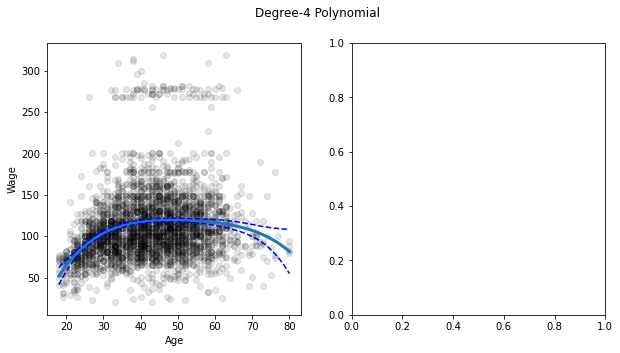

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Degree-4 Polynomial')

ax[0].scatter(age, Wage.wage, color='k', alpha=0.1)
ax[0].plot(age_grid, pred.predicted_mean, lw=3)
ax[0].plot(age_grid, pred.conf_int(), '--b')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Wage');

In performing a polynomial regression we must decide on the degree of
the polynomial to use. One way to do this is by using hypothesis
tests. We now fit models ranging from linear to a degree-5 polynomial
and seek to determine the simplest model which is sufficient to
explain the relationship 
between `wage` and `age`. We use the
`anova_lm()` function, which performs an analysis of
  variance (ANOVA, using an F-test) in order to test the null
hypothesis that a model $\mathcal{M}_1$ is sufficient to explain the
data against the alternative hypothesis that a more complex model
$\mathcal{M}_2$ is required. In order to use the `anova_lm()`
function, $\mathcal{M}_1$ and $\mathcal{M}_2$ must be *nested*
models: the predictors in $\mathcal{M}_1$ must be a subset of the
predictors in $\mathcal{M}_2$. In this case, we fit five different
models and sequentially compare the simpler model to the more complex
model.

In [51]:
X1 = PolynomialFeatures(1).fit_transform(Wage.age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(Wage.age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(Wage.age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(Wage.age.values.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(Wage.age.values.reshape(-1,1))

In [53]:
fit_1 = sm.OLS(Wage.wage, X1).fit()
fit_2 = sm.OLS(Wage.wage, X2).fit()
fit_3 = sm.OLS(Wage.wage, X3).fit()
fit_4 = sm.OLS(Wage.wage, X4).fit()
fit_5 = sm.OLS(Wage.wage, X5).fit()

In [54]:
sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


The p-value comparing the linear `Model 1` to the quadratic
`Model 2` is essentially zero ($<$$10^{-15}$), indicating that a linear
fit is not sufficient. Similarly the p-value comparing the quadratic
 `Model 2` to the cubic `Model 3` is very low ($0.0017$), so
the quadratic fit is also insufficient. The p-value comparing the
cubic and degree-4 polynomials, `Model 3` and `Model 4`, is approximately $5\,\%$
while the degree-5 polynomial `Model 5` seems unnecessary because its
p-value is $0.37$. Hence, either a cubic or a quartic
polynomial appear to provide a reasonable fit to the data, but lower-
or higher-order models are not justified.

The ANOVA method also works when we have other terms in the model as well. For example, we can use `anova_lm()` to compare these three models:

In [69]:
education = pd.get_dummies(Wage.education, drop_first=True).values

In [73]:
fit_1 = sm.OLS(Wage.wage, np.column_stack([X1, education])).fit()
fit_2 = sm.OLS(Wage.wage, np.column_stack([X2, education])).fit()
fit_3 = sm.OLS(Wage.wage, np.column_stack([X3, education])).fit()
sm.stats.anova_lm(fit_1, fit_2, fit_3, typ=1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2994.0,3.867992e+06,0.0,NaN,NaN,NaN
1,2993.0,3.725395e+06,1.0,142597.097010,114.696898,2.728001e-26
2,2992.0,3.719809e+06,1.0,5586.660322,4.493588,3.410431e-02


As an alternative to using hypothesis tests and ANOVA, we could choose the polynomial degree using  cross-validation, as discussed in Chapter 5.

Next we consider the task of predicting whether an individual earns more than $\$250,000$ per year. We proceed much as before, except that first we create the appropriate response vector, and then apply the `GLM()` function with a binomial family paremeter in order to fit a polynomial logistic regression model.

In [95]:
y = (Wage.wage > 250).astype(int)

fit = sm.GLM(y, X4, family=sm.families.Binomial()).fit()

The expression `wage > 250` evaluates to a logical variable containing `True`s and `False`s, which we then cast to binary by setting the `True`s to 1 and the `False`s to 0.

Once again, we make predictions using the `get_prediction()` function.

In [101]:
preds = fit.get_prediction(PolynomialFeatures(4).fit_transform(age_grid[:, None]))

Finally, the right-hand plot from Figure 7.1 was made as follows:

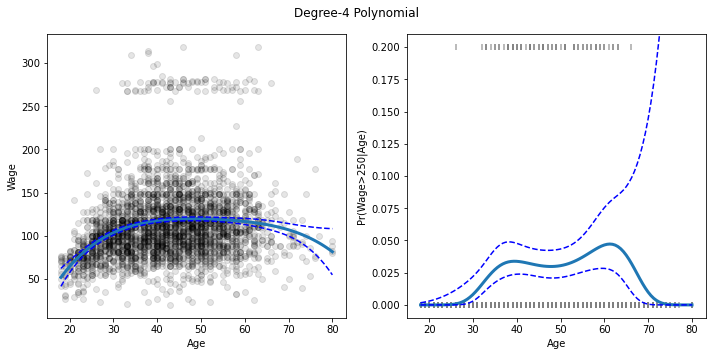

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Degree-4 Polynomial')

ax[0].scatter(age, Wage.wage, color='k', alpha=0.1)
ax[0].plot(age_grid, pred.predicted_mean, lw=3)
ax[0].plot(age_grid, pred.conf_int(), '--b')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Wage')


ax[1].plot(age_grid, preds.predicted_mean, lw=3)
ax[1].plot(age_grid, preds.conf_int(), '--b')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Pr(Wage>250|Age)')
ax[1].set_ylim(-0.01, 0.21)
# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax[1].scatter(Wage.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

plt.tight_layout();

We have drawn  the `age` values corresponding to the observations with `wage` values above $250$ as gray marks on the top of the plot, and those with `wage` values below $250$ are shown as gray marks on the bottom of the plot. 

## Step functions

In order to fit a step function, as discussed in Section 7.2, we use the `cut()` function.

In [183]:
Wages_cut, bins = pd.cut(Wage.age, bins=4, retbins=True, right=True)
Wages_cut.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

Here cut() automatically picked the cutpoints at 33.5, 49, and 64.5 years of age. The function `cut()` returns an ordered categorical variable. We could also have specified our own cutpoints directly. Now let's create a set of dummy variables for use in the regression:

In [184]:
age_dummies = pd.get_dummies(Wages_cut)
age_dummies = age_dummies.drop(columns=age_dummies.columns[0])
fit = sm.OLS(Wage.wage, sm.add_constant(age_dummies)).fit()
fit.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.264,97.053
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.466,27.641
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.610,27.719
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.139,17.420


The `age < 33.5` category is left out, so the intercept coefficient of $94{,}160$ can be interpreted as the average salary for those under $33.5$ years of age, and the other coefficients can be interpreted as the average additional salary for those in the other age groups.
We can produce predictions and plots just as we did in the case of the polynomial fit.


In [185]:
# Grid dummies with same columns
age_grid_dummies = pd.get_dummies(pd.cut(age_grid, bins=bins))[age_dummies.columns]

# Linear model
pred = fit.get_prediction(sm.add_constant(age_grid_dummies))

# Logistic model
fit2 = sm.GLM(y, sm.add_constant(age_dummies), family=sm.families.Binomial()).fit()
preds = fit2.get_prediction(sm.add_constant(age_grid_dummies))

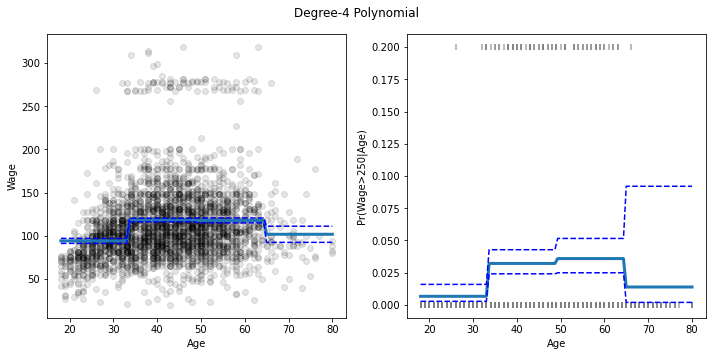

In [186]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Degree-4 Polynomial')

ax[0].scatter(age, Wage.wage, color='k', alpha=0.1)
ax[0].plot(age_grid, pred.predicted_mean, lw=3)
ax[0].plot(age_grid, pred.conf_int(), '--b')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Wage')


ax[1].plot(age_grid, preds.predicted_mean, lw=3)
ax[1].plot(age_grid, preds.conf_int(), '--b')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Pr(Wage>250|Age)')
ax[1].set_ylim(-0.01, 0.21)
# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax[1].scatter(Wage.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

plt.tight_layout();

## Splines

In [187]:
from patsy import dmatrix

In order to fit regression splines in `Python`, we use the `patsy` library.
In Section 7.4, we saw that regression
splines can be fit by constructing an appropriate matrix of basis functions.
The `bs()` function generates the entire matrix of basis functions for splines with the specified set of knots. By default, cubic splines are produced.
Fitting `wage` to `age` using a regression spline is simple:

In [216]:
# Specifying 3 knots
transformed_x1 = dmatrix("bs(age, knots=(25, 40, 60), degree=3, include_intercept=False)",
                         Wage, return_type='dataframe')

# Build a regular linear model from the splines
fit1 = sm.GLM(Wage.wage, transformed_x1).fit()

# Get new data in the same basis
age_grid_1 = dmatrix("bs(age_grid, knots=(25, 40, 60), degree=3, include_intercept=False)",
                         return_type='dataframe')

pred1 = fit1.get_prediction(age_grid_1)

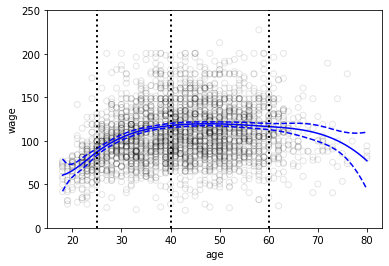

In [236]:
# Plot the splines and error bands
plt.scatter(Wage.age, Wage.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred1.predicted_mean, color='b')
plt.plot(age_grid, pred1.conf_int(), '--b')
[plt.vlines(i , 0, 350, linestyles='dotted', lw=2, colors='k') for i in [25,40,60]]
plt.xlabel('age')
plt.ylabel('wage')
plt.ylim(0, 250);

Here we have prespecified knots at ages $25$, $40$, and $60$. This produces a spline with six basis functions. (Recall that a cubic spline with three knots has seven degrees of freedom; these degrees of freedom are used up by an intercept, plus six basis functions.) We could also use the `df` option to produce a spline with knots at uniform quantiles
of the data.

In [243]:
# Specifying 6 degrees of freedom 
transformed_x2 = dmatrix("bs(age, df=6, include_intercept=False)",
                         Wage, return_type='dataframe')
fit2 = sm.GLM(Wage.wage, transformed_x2).fit()

# Get new data in the same basis
age_grid_2 = dmatrix("bs(age_grid, df=6, include_intercept=False)",
                         return_type='dataframe')

pred2 = fit2.get_prediction(age_grid_2)

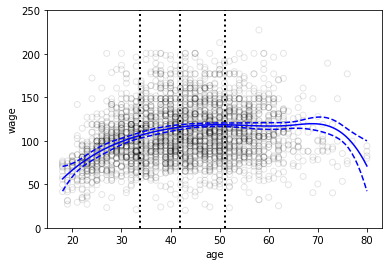

In [244]:
# Plot the splines and error bands
plt.scatter(Wage.age, Wage.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred2.predicted_mean, color='b')
plt.plot(age_grid, pred2.conf_int(), '--b')
[plt.vlines(i , 0, 350, linestyles='dotted', lw=2, colors='k') for i in [33.8, 42.0, 51.0]]
plt.xlabel('age')
plt.ylabel('wage')
plt.ylim(0, 250);

In this case `Python` chooses knots at ages $33.8, 42.0$, and $51.0$, which correspond to the 25th, 50th, and 75th percentiles of `age`. The function `bs()` also has a `degree` argument, so we can fit splines of any degree, rather than the default degree of 3 (which yields a cubic spline).

In order to instead fit a natural spline, we use the `cr()` function. 
Here we fit a natural spline with four degrees of freedom.

In [230]:
# Specifying 4 degrees of freedom
transformed_x3 = dmatrix("cr(age, df=4)", Wage, return_type='dataframe')
fit3 = sm.GLM(Wage.wage, transformed_x3).fit()
# Get new data in the same basis
age_grid_3 = dmatrix("cr(age_grid, df=4)", return_type='dataframe')

pred3 = fit3.get_prediction(age_grid_3)

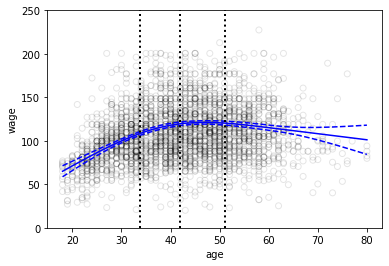

In [245]:
# Plot the splines and error bands
plt.scatter(Wage.age, Wage.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred3.predicted_mean, color='b')
plt.plot(age_grid, pred3.conf_int(), '--b')
[plt.vlines(i , 0, 350, linestyles='dotted', lw=2, colors='k') for i in [33.8, 42.0, 51.0]]
plt.xlabel('age')
plt.ylabel('wage')
plt.ylim(0, 250);

As with the `bs()` function, we could instead specify the knots directly using the `knots` option.

In order to fit a smoothing spline, we use
the `smooth.spline()` from `R`, since there is not yet an available module for smoothing splines in Python.

In [267]:
import rpy2.robjects as robjects

r_x = robjects.FloatVector(Wage.age)
r_y = robjects.FloatVector(Wage.wage)
r_grid = robjects.FloatVector(age_grid)
r_smooth_spline = robjects.r['smooth.spline'] #extract R function

fit1 = r_smooth_spline(x=r_x, y=r_y, df=16)
fit2 = r_smooth_spline(x=r_x, y=r_y, cv=True)

fit2.rx2('df')

6.794596


Notice that in the first call to `smooth.spline()`, we specified `df = 16`. The function then  determines which value of $\lambda$  leads to $16$ degrees of freedom.
 In the second call to `smooth.spline()`, we select the smoothness level by cross-validation;
 this results in a value of $\lambda$ that yields 6.8 degrees of freedom.

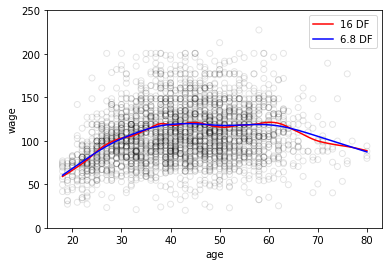

In [269]:
ySpline1 = np.array(robjects.r['predict'](fit1, robjects.FloatVector(r_grid)).rx2('y'))
ySpline2 = np.array(robjects.r['predict'](fit2, robjects.FloatVector(r_grid)).rx2('y'))

plt.scatter(Wage.age, Wage.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, ySpline1, color='r', label='16 DF')
plt.plot(age_grid, ySpline2, color='b', label='6.8 DF')
plt.xlabel('age')
plt.ylabel('wage')
plt.legend()
plt.ylim(0, 250);

In order to perform local regression, we use the `loess()` function. 

In [275]:
lowess = sm.nonparametric.lowess

fit1 = lowess(Wage.wage, Wage.age, frac=0.2, xvals=age_grid)
fit2 = lowess(Wage.wage, Wage.age, frac=0.5, xvals=age_grid)

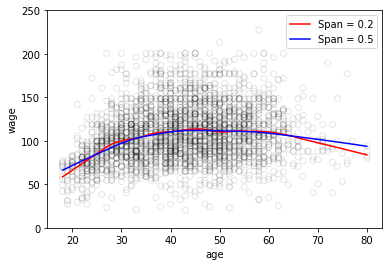

In [277]:
plt.scatter(Wage.age, Wage.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, fit1, color='r', label='Span = 0.2')
plt.plot(age_grid, fit2, color='b', label='Span = 0.5')
plt.xlabel('age')
plt.ylabel('wage')
plt.legend()
plt.ylim(0, 250);

Here we have performed local linear regression using spans of $0.2$ and $0.5$: that is, each neighborhood consists of 20\,\% or 50\,\% of the observations. The larger the span, the smoother the fit.

## GAMs

What follows is the original R code for the GAMs portion of the lab. A good GAM package is missing from the Python ecosystem, though pyGAM is looks promising. We defer work on this section for later, at which point we'll need to decide wether to implment a subset of the section in PyGAM or call the R code from within Python as we did with in the subsection on smoothing splines.

We now fit a GAM to predict `wage` using natural spline functions of `lyear` and `age`,  treating `education` as a qualitative predictor, as in (7.16). Since this is just a big linear regression model using an appropriate choice of basis functions, we can simply do this using the `lm()` function.

In [ ]:
gam1 <- lm(wage ~ ns(year, 4) + ns(age, 5) + education,
    data = Wage)

We now fit the model (7.16) using smoothing splines rather than natural splines.  In order to fit more general sorts of GAMs, using smoothing splines or other components that cannot be expressed in terms of basis functions and then fit using least squares regression, we will need to use the `gam` library in `R`.

The `s()` function, which is part of the `gam` library, is used to indicate that we would like to use a smoothing spline. We specify that the function of `lyear` should have $4$ degrees of freedom, and that the function of `age` will have $5$ degrees of freedom. Since `education` is qualitative, we leave it as is, and it is converted into four dummy variables. We use the `gam()` function in order to fit a GAM using these components.
 All of the terms in (7.16) are fit simultaneously, taking each other into account to explain the response.

In [ ]:
library(gam)
gam.m3 <- gam(wage ~ s(year, 4) + s(age, 5) + education,
    data = Wage)

In order to produce  Figure 7.12, we simply call the `plot()` function:

In [ ]:
par(mfrow = c(1, 3))
plot(gam.m3, se = TRUE, col = "blue")

The generic `plot()` function recognizes that `gam.m3` is an
object of class `Gam`, and invokes the appropriate
`plot.Gam()` method.  Conveniently, even though
  `gam1` is not of class `Gam` but rather of class `lm`, we can {\em
  still} use `plot.Gam()` on it.  Figure 7.11 was produced using the following expression:

In [ ]:
plot.Gam(gam1, se = TRUE, col = "red")

Notice here we had to use `plot.Gam()` rather than the *generic* `plot()` function.

In these plots, the function of `lyear` looks rather linear. We can perform a series of ANOVA tests in order to determine which of these three models is best:  a GAM that excludes `lyear` ($\mathcal{M}_1$),  a GAM that uses a linear function of `lyear` ($\mathcal{M}_2$), or  a GAM that uses a spline function
of `lyear` ($\mathcal{M}_3$).

In [ ]:
gam.m1 <- gam(wage ~ s(age, 5) + education, data = Wage)
gam.m2 <- gam(wage ~ year + s(age, 5) + education,
    data = Wage)
anova(gam.m1, gam.m2, gam.m3, test = "F")

We find that there is compelling evidence that a GAM with a linear function of `lyear` is better than a GAM that does not include `lyear` at all \hbox{(p-value\,=\,0.00014).} However, there is no evidence that a non-linear function of `lyear` is needed (p-value\,=\,0.349).
In other words, based on the results of this ANOVA, $\mathcal{M}_2$ is preferred.

The `summary()` function produces a summary of the gam fit.

In [ ]:
summary(gam.m3)

The ``Anova for Parametric Effects" p-values clearly demonstrate that `year`, `age`, and `education` are all highly statistically significant, even when only assuming a linear relationship. Alternatively, the ``Anova for Nonparametric Effects" p-values for `year` and `age` correspond to a null hypothesis of a linear relationship versus the alternative of a non-linear relationship. The large p-value for `year` reinforces our conclusion from the ANOVA test that a linear function is adequate for this term. However, there is very clear evidence that a non-linear term is required for `age`.

We can make predictions
using the `predict()` method for the class `Gam`.
 Here we make predictions on the training set.

In [ ]:
preds <- predict(gam.m2, newdata = Wage)

We can also use local regression fits as building blocks in a GAM, using the `lo()` function.

In [ ]:
gam.lo <- gam(
    wage ~ s(year, df = 4) + lo(age, span = 0.7) + education,
    data = Wage
  )
plot.Gam(gam.lo, se = TRUE, col = "green")

Here we have used local regression for the `age` term, with a span of
$0.7$.
We can also use the `lo()` function to create interactions before calling the `gam()` function. For example,

In [ ]:
gam.lo.i <- gam(wage ~ lo(year, age, span = 0.5) + education,
    data = Wage)

fits a two-term model, in which the first term is an interaction between `lyear` and `age`, fit by a local regression surface. We can plot the resulting two-dimensional surface if we first install the `akima` package.

In [ ]:
library(akima)
plot(gam.lo.i)

In order to fit a logistic regression GAM, we once again use the `I()` function in constructing the binary response variable, and set `family=binomial`.

In [ ]:
gam.lr <- gam(
    I(wage > 250) ~ year + s(age, df = 5) + education,
    family = binomial, data = Wage
  )
par(mfrow = c(1, 3))
plot(gam.lr, se = T, col = "green")

It is easy to see that there are no high earners in the `< HS` category:

In [ ]:
table(education, I(wage > 250))

Hence, we fit a logistic regression GAM using all but this category. This provides more sensible results.

In [ ]:
gam.lr.s <- gam(
    I(wage > 250) ~ year + s(age, df = 5) + education,
    family = binomial, data = Wage,
    subset = (education != "1. < HS Grad")
  )
plot(gam.lr.s, se = T, col = "green")